In [12]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import s2sphere as s2
import matplotlib.pyplot as plt
import haversine

In [13]:
dset = 'sandy' # one of : sandy, all, harvey
n_bins = 4 

In [14]:
def get_s2cell(lat, long, level):
    generator_obj = s2.CellId().from_lat_lng(s2.LatLng.from_degrees(lat, long)).parent(level)
    token = generator_obj.to_token()
    lat = generator_obj.to_lat_lng().lat().degrees
    lng = generator_obj.to_lat_lng().lng().degrees
    return (token, lat, lng)
get_s2cells = lambda df, level=14: pd.DataFrame(df.apply(lambda row: get_s2cell(row['lat_x'], row['lon_x'], level), axis=1).tolist(), columns=['token', 'slat', 'slng'])

norm = lambda df : la.norm(df.values, axis=1)



In [15]:
all_tweets = pd.read_pickle(f"../data/pickles/{dset}/cleanmoji.pkl")#.head(1000)
all_tweets['created_at_date'] = pd.to_datetime(all_tweets['created_at'], infer_datetime_format=True)
all_tweets = all_tweets.merge(get_s2cells(all_tweets), left_index=True, right_index=True)
all_tweets.set_index('created_at_date', inplace=True)
plot = all_tweets.resample('1H').mean()[['slat', 'slng', 'Sent_1']]
track = pd.read_pickle("../data/pickles/track.pkl")
track['TIME_'] = track['TIME_'].dt.tz_localize("UTC")
track = track[['TIME_', 'LAT', 'LON', 'INTENSITY']]#.set_index("TIME_")
us_tweets = all_tweets[all_tweets['cc'] == "US"]
all_tweets['cc'].unique(), all_tweets.columns


(array(['US', 'MX', 'ZA', 'GH', 'BR', 'GB', 'DO', 'CA', 'MY', 'MN', 'KY',
        'JP', 'ID', 'JM', 'PR', 'GP', 'CH', 'TH', 'NG', 'ES', 'NO', 'AU',
        'IE', 'KE', 'MV', 'BS', 'SA', 'LB', 'TR', 'VE', 'NL', 'UA', 'VI',
        'PH', 'CO', 'HT', 'RU', 'BB', 'IT', 'FR', 'BE', 'EC', 'CL', 'BM',
        'NE', 'SG', 'SE', 'AE', 'IN', 'TT', 'TW', 'KW', 'KN', 'CR', 'EG',
        'PE', 'KR', 'CN', 'IL', 'DE', 'PT', 'PA', 'BH', 'ZM', 'PY', 'CI',
        'AR', 'UG', 'MS', 'QA'], dtype=object),
 Index(['full_text', 'created_at', 'id', 'lon_x', 'lat_x', 'lat_y', 'lon_y',
        'name', 'admin1', 'admin2', 'cc', 'Text', 'Top5%', 'Emoji_1', 'Emoji_2',
        'Emoji_3', 'Emoji_4', 'Emoji_5', 'Pct_1', 'Pct_2', 'Pct_3', 'Pct_4',
        'Pct_5', 'Sent_1', 'Sent_2', 'Sent_3', 'Sent_4', 'Sent_5', 'token',
        'slat', 'slng'],
       dtype='object'))

In [16]:
sandy_tweets = pd.merge_asof(all_tweets.sort_index().reset_index(), track, left_on='created_at_date', right_on='TIME_', direction='nearest')
sandy_tweets.shape



(37670, 36)

In [17]:
train = sandy_tweets[['created_at_date', 'full_text', 'LAT', 'LON', 'lat_x', 'lon_x'] + [f'Sent_{i+1}' for i in range(5)]]
train['dist'] = haversine.haversine_vector(train[['lat_x', 'lon_x']].values, train[['LAT', 'LON']].values, unit='km')

In [18]:
train = train.rename({
    'created_at_date' : 'date',
    'full_text' : 'text',
    'LAT' : 'hlat',
    'LON' : 'hlon',
    'lat_x' : 'tlat',
    'lon_x' : 'tlon',
    'Sent_1' : 'sent',
}, axis='columns')[['date', 'text', 'hlat', 'hlon', 'tlat', 'tlon', 'sent', 'dist']]

<AxesSubplot:>

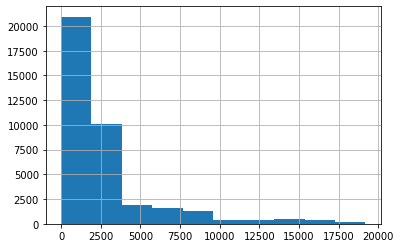

In [19]:
train['dist'].hist()

In [20]:

train['label'], dists = pd.cut(train['dist'], bins=n_bins, labels=[i for i in range(n_bins)],retbins=True, precision=1)
dists

array([  -19.17923239,  4794.80809747,  9589.61619494, 14384.42429241,
       19179.23238988])

In [21]:
train.to_pickle(f"../data/pickles/{dset}/train.pkl", protocol=4)

In [22]:
train.head()

,date,text,hlat,hlon,tlat,tlon,sent,dist,label
0,2011-08-20 22:14:42+00:00,Tracking Invest 97L: http://t.co/HtCnsWE How...,14.3,-77.4,49.549079,7.885645,0.194,8465.882878,1
1,2011-08-20 22:33:35+00:00,ATCF shows initial intensity of Tropical Storm...,14.3,-77.4,49.549079,7.885645,0.521,8465.882878,1
2,2011-08-20 23:17:11+00:00,Tropical Storm Irene has arrived. Could enter...,14.3,-77.4,40.110547,-88.244397,0.521,3057.961870,0
3,2011-08-20 23:21:03+00:00,NEW AL basin: TROPICAL STORM IRENE @ 23:00UTC ...,14.3,-77.4,14.900000,-58.500000,-0.534,2034.216337,0
4,2011-08-20 23:21:04+00:00,NEW AL basin: TROPICAL STORM IRENE @ 23:00UTC ...,14.3,-77.4,14.900000,-58.500000,-0.534,2034.216337,0
